<a href="https://colab.research.google.com/github/sonyerim/BK21/blob/main/CH07%26CH08%26CH09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 7.5.1 4장, 5장, 6장의 데이터 집합에 ARIMA(p,d,q) 모델 적용하기

## CH04

In [10]:
df_ch4 = pd.read_csv('../widget_sales.csv')

df_ch4.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


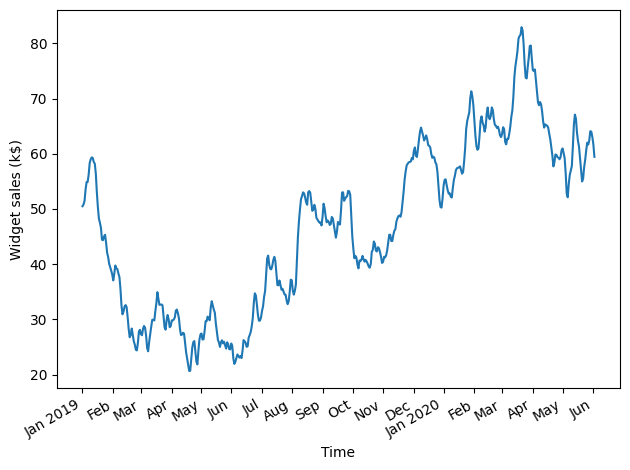

In [11]:
fig, ax = plt.subplots()

ax.plot(df_ch4['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498],
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

In [12]:
ad_fuller_result = adfuller(df_ch4['widget_sales'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.5121662069359048
p-value: 0.5274845352272605


In [13]:
df_ch4_diff = np.diff(df_ch4['widget_sales'], n=1)

ad_fuller_result = adfuller(df_ch4_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -10.576657780341959
p-value: 7.076922818587193e-19


In [14]:
train = df_ch4[:-50]
test = df_ch4[-50:]

print(len(test))

50


In [15]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [16]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

In [17]:
result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",1251.425849
1,"(0, 2)",1254.409302
2,"(2, 1)",1254.961827
3,"(0, 3)",1255.826822
4,"(3, 0)",1255.967595
5,"(1, 2)",1255.982548
6,"(1, 1)",1256.284513
7,"(3, 1)",1256.850863
8,"(2, 2)",1256.918179
9,"(1, 3)",1257.643258


In [18]:
model = SARIMAX(train, order=(3,1,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           widget_sales   No. Observations:                  450
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -618.713
Date:                Tue, 15 Apr 2025   AIC                           1251.426
Time:                        07:29:14   BIC                           1280.175
Sample:                             0   HQIC                          1262.758
                                - 450                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3628      0.064     21.194      0.000       1.237       1.489
ar.L2         -1.3526      0.065    -20.846      0.000      -1.480      -1.225
ar.L3          0.3508      0.064      5.460      0.0

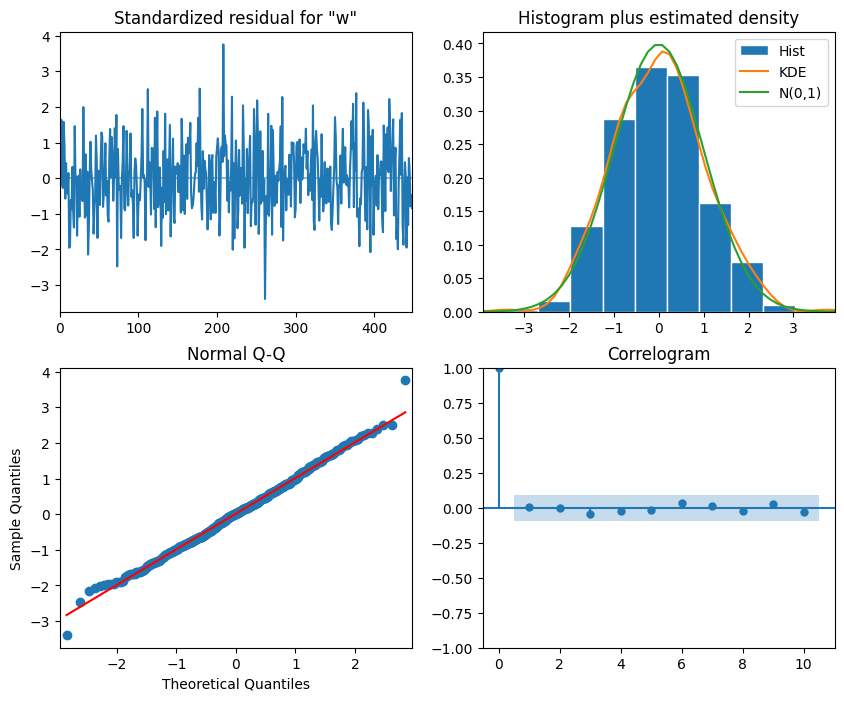

In [19]:
model_fit.plot_diagnostics(figsize=(10,8));

In [20]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [21]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'ARIMA':
        pred_ARIMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,1,3))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)

        return pred_ARIMA

In [22]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_ch4, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_ch4, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df_ch4, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARIMA'] = pred_ARIMA

test.head()

,widget_sales,pred_mean,pred_last_value,pred_ARIMA
450,64.736005,45.472231,65.906136,64.811784
451,65.316972,45.472231,65.906136,64.718856
452,65.172070,45.558754,65.316972,66.241317
453,65.075506,45.558754,65.316972,66.606349
454,64.703173,45.644943,65.075506,64.993952


In [23]:
from sklearn.metrics import mean_absolute_error

mean_mae = mean_absolute_error(test['widget_sales'], test['pred_mean'])
last_mae = mean_absolute_error(test['widget_sales'], test['pred_last_value'])
ARIMA_mae = mean_absolute_error(test['widget_sales'], test['pred_ARIMA'])

print(mean_mae, last_mae, ARIMA_mae)

14.220336729946744 1.819226540180243 1.572447759552384


## CH05

In [24]:
df_ch5 = pd.read_csv('../foot_traffic.csv')

df_ch5.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


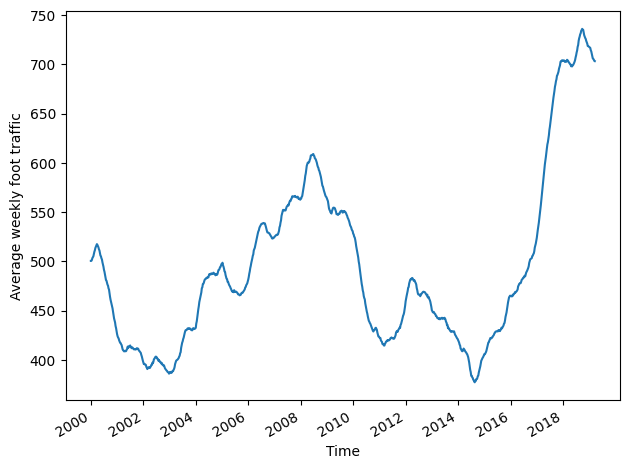

In [25]:
fig, ax = plt.subplots()

ax.plot(df_ch5['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [26]:
ad_fuller_result = adfuller(df_ch5['foot_traffic'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -1.1758885999240747
p-value: 0.683880891789619


In [27]:
df_ch5_diff = np.diff(df_ch5['foot_traffic'], n=1)

ad_fuller_result = adfuller(df_ch5_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.268231347422044
p-value: 6.369317654781239e-06


In [28]:
train = df_ch5[:-52]
test = df_ch5[-52:]

print(len(test))

52


In [29]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

In [30]:
result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 3)",2658.013441
1,"(3, 1)",2658.595081
2,"(3, 0)",2658.691777
3,"(2, 1)",2659.873751
4,"(3, 2)",2659.916852
5,"(2, 3)",2659.977855
6,"(3, 3)",2660.802094
7,"(2, 2)",2661.229924
8,"(2, 0)",2667.725827
9,"(1, 2)",2669.719835


In [31]:
model = SARIMAX(train, order=(3,1,0), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           foot_traffic   No. Observations:                  948
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -1325.346
Date:                Tue, 15 Apr 2025   AIC                           2658.692
Time:                        07:29:27   BIC                           2678.105
Sample:                             0   HQIC                          2666.090
                                - 948                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3165      0.033      9.603      0.000       0.252       0.381
ar.L2          0.4802      0.031     15.510      0.000       0.419       0.541
ar.L3          0.1077      0.034      3.156      0.0

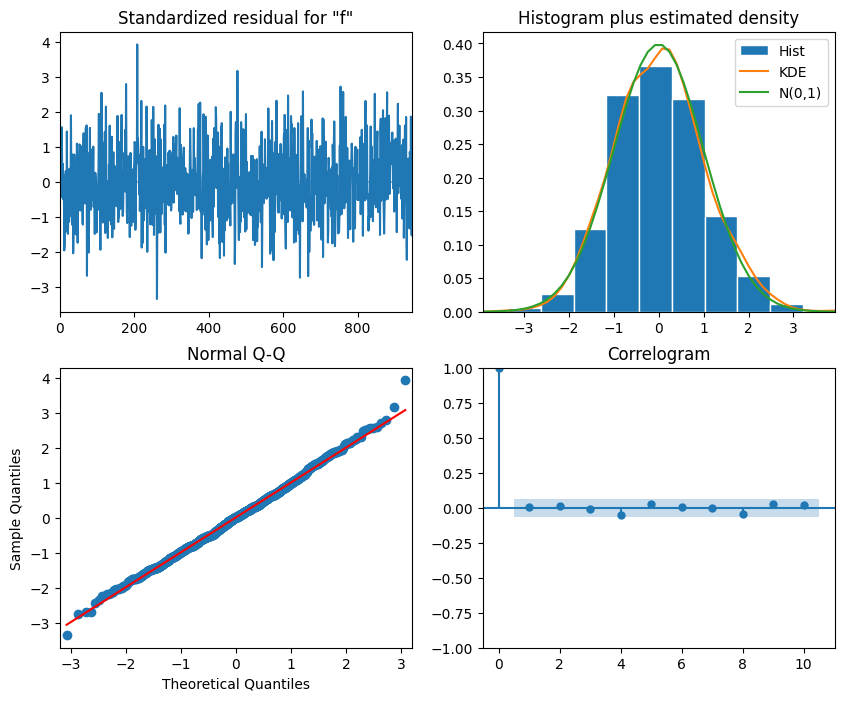

In [32]:
model_fit.plot_diagnostics(figsize=(10,8));

In [33]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [34]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'ARIMA':
        pred_ARIMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,1,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)

        return pred_ARIMA

In [35]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1    # Use a window of 1, just like in chapter 5

pred_mean = rolling_forecast(df_ch5, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_ch5, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df_ch5, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARIMA'] = pred_ARIMA

test.head()

,foot_traffic,pred_mean,pred_last_value,pred_ARIMA
948,701.686830,481.204906,702.463430,701.743717
949,701.112198,481.437237,701.686830,700.872282
950,700.221501,481.668474,701.112198,700.447460
951,699.937948,481.898288,700.221501,699.580032
952,698.107264,482.127321,699.937948,699.358669


In [36]:
from sklearn.metrics import mean_absolute_error

mean_mae = mean_absolute_error(test['foot_traffic'], test['pred_mean'])
last_mae = mean_absolute_error(test['foot_traffic'], test['pred_last_value'])
ARIMA_mae = mean_absolute_error(test['foot_traffic'], test['pred_ARIMA'])

print(mean_mae, last_mae, ARIMA_mae)

227.9348827539398 1.4751845139589823 0.7524469762185547


## CH06

In [37]:
df_ch6 = pd.read_csv('../bandwidth.csv')

df_ch6.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


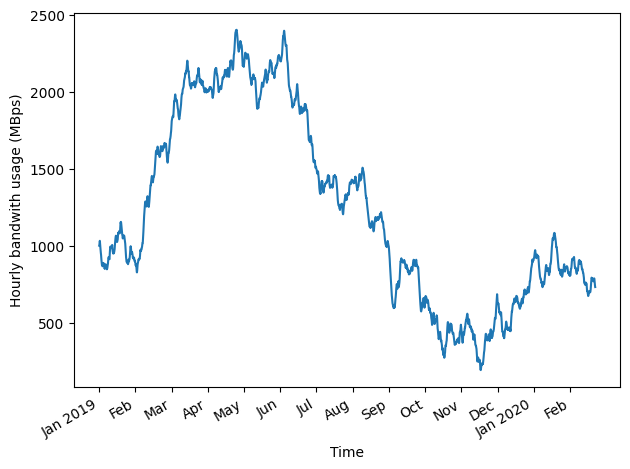

In [38]:
fig, ax = plt.subplots()

ax.plot(df_ch6['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

plt.xticks(
    np.arange(0, 10000, 730),
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

In [39]:
ad_fuller_result = adfuller(df_ch6['hourly_bandwidth'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.8714653199452735
p-value: 0.7972240255014551


In [40]:
df_ch6_diff = np.diff(df_ch6['hourly_bandwidth'], n=1)

ad_fuller_result = adfuller(df_ch6_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -20.694853863789017
p-value: 0.0


In [41]:
train = df_ch6[:-168]
test = df_ch6[-168:]

print(len(train))
print(len(test))

9832
168


In [42]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 1

order_list = list(product(ps, qs))

In [43]:
result_df = optimize_ARIMA(train, order_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 2)",27991.063157
1,"(2, 3)",27991.286794
2,"(2, 2)",27991.602936
3,"(3, 3)",27993.416226
4,"(1, 3)",28003.348864
5,"(1, 2)",28051.350913
6,"(3, 1)",28071.155049
7,"(3, 0)",28095.617602
8,"(2, 1)",28097.250206
9,"(2, 0)",28098.407146


In [44]:
model = SARIMAX(train, order=(2,1,2), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       hourly_bandwidth   No. Observations:                 9832
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -13990.801
Date:                Tue, 15 Apr 2025   AIC                          27991.603
Time:                        07:30:03   BIC                          28027.569
Sample:                             0   HQIC                         28003.788
                               - 9832                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.0

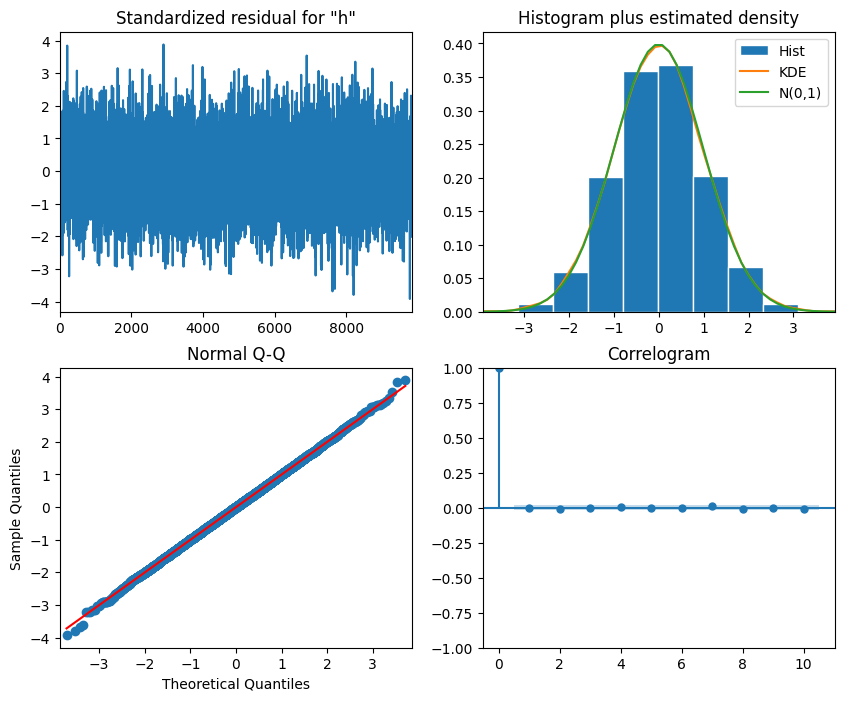

In [45]:
model_fit.plot_diagnostics(figsize=(10,8));

In [46]:
residuals = model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [47]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'ARIMA':
        pred_ARIMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,1,2))    # Set the right ARIMA parameters
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)

        return pred_ARIMA

In [48]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2    # Use a window of 2, just like in chapter 6

pred_mean = rolling_forecast(df_ch6, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_ch6, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df_ch6, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARIMA'] = pred_ARIMA

test.head()

,hourly_bandwidth,pred_mean,pred_last_value,pred_ARIMA
9832,717.176939,1241.072644,723.120934,717.660272
9833,711.311745,1241.072644,723.120934,712.769646
9834,708.114679,1240.965500,711.311745,705.975840
9835,707.024482,1240.965500,711.311745,701.224109
9836,707.689774,1240.857042,707.024482,706.648886


In [49]:
mean_mae = mean_absolute_error(test['hourly_bandwidth'], test['pred_mean'])
last_mae = mean_absolute_error(test['hourly_bandwidth'], test['pred_last_value'])
ARIMA_mae = mean_absolute_error(test['hourly_bandwidth'], test['pred_ARIMA'])

print(mean_mae, last_mae, ARIMA_mae)

497.927419811828 2.8444991498767638 1.3844224607169648


# 8.5.1 존슨앤드존슨 데이터 집합에 SARIMA(p,d,q)(P,D,Q)m 모델 적용하기

In [50]:
# 데이터 수집
df = pd.read_csv('../jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


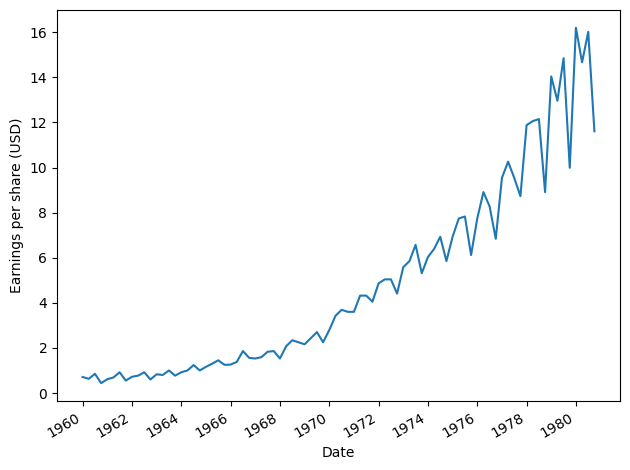

In [51]:
# 도식화
fig, ax = plt.subplots()

ax.plot(df.date, df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()


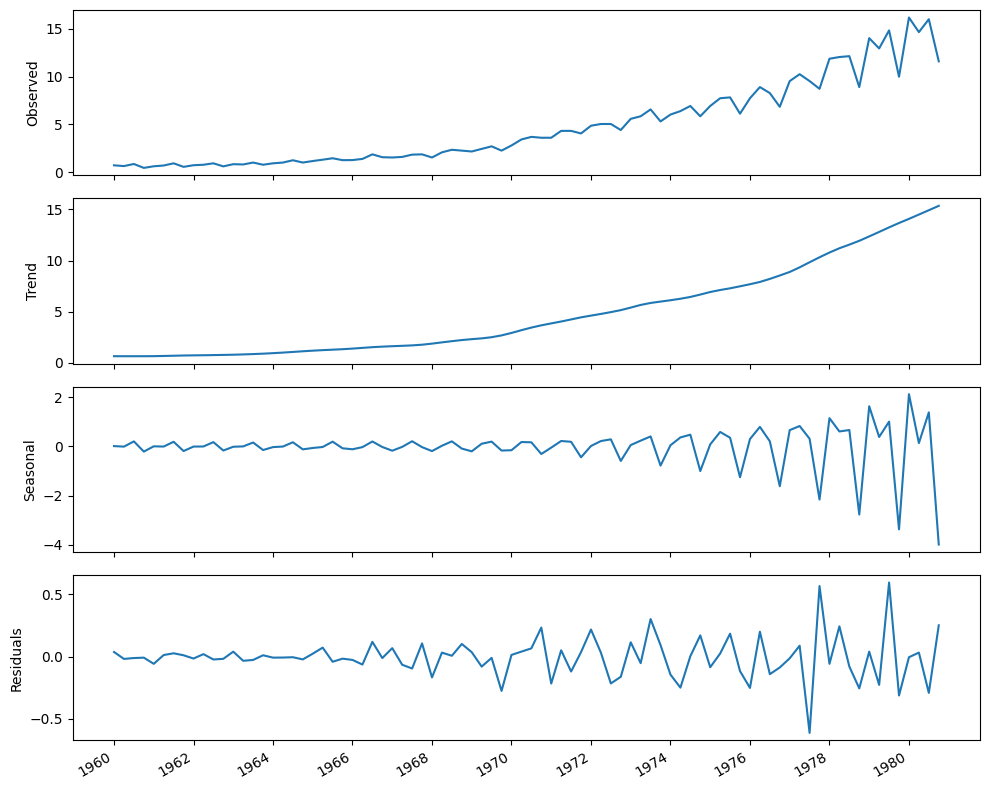

In [52]:
# 시계열 분해 -> 주기적 패턴의 존재 식별
decomposition = STL(df['data'], period=4).fit() # 분기별

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [53]:
# 정상성 테스트 -> 비정상
ad_fuller_result = adfuller(df['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.7420165734574744
p-value: 1.0


In [54]:
# 1차 차분
df_diff = np.diff(df['data'], n=1)

ad_fuller_result = adfuller(df_diff)

# 정상성 테스트 -> 비정상
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.40740976363804615
p-value: 0.9088542416911305


In [55]:
# 계절적 차분
df_diff_seasonal_diff = np.diff(df_diff, n=4)

ad_fuller_result = adfuller(df_diff_seasonal_diff)

# 정상성 테스트 -> 정상
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.032499262650834
p-value: 1.4070571055600886e-07


In [56]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [57]:
# 데이터 분할
train = df[:-4]
test = df[-4:]

In [58]:
# 가능한 값의 범위 정의
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

# 차수들의 고유한 조합 생성
SARIMA_order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
s = 4 # 분기별

# 모델 피팅 및 AIC가 가장 낮은 모델 선택 -> SARIMA(3,1,0)(2,1,1)4
SARIMA_result_df = optimize_SARIMA(train['data'], SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 0, 2, 1)",88.829232
1,"(1, 2, 0, 0)",89.609996
2,"(3, 1, 0, 0)",89.677549
3,"(1, 3, 0, 0)",89.734026
4,"(2, 2, 0, 0)",90.178107
...,...,...
251,"(0, 0, 3, 2)",136.749059
252,"(0, 0, 2, 3)",136.768920
253,"(0, 0, 0, 0)",137.133568
254,"(0, 0, 1, 3)",137.761947


In [59]:
# 잔차 진단 도식화 -> 잔차가 백색소음과 유사함
SARIMA_model = SARIMAX(train['data'], order=(3,1,0), seasonal_order=(2,1,1,4), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                data   No. Observations:                   80
Model:             SARIMAX(3, 1, 0)x(2, 1, [1], 4)   Log Likelihood                 -37.415
Date:                             Tue, 15 Apr 2025   AIC                             88.829
Time:                                     07:33:28   BIC                            105.052
Sample:                                          0   HQIC                            95.307
                                              - 80                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8204      0.114     -7.181      0.000      -1.044      -0.596
ar.L2         -0.3646      

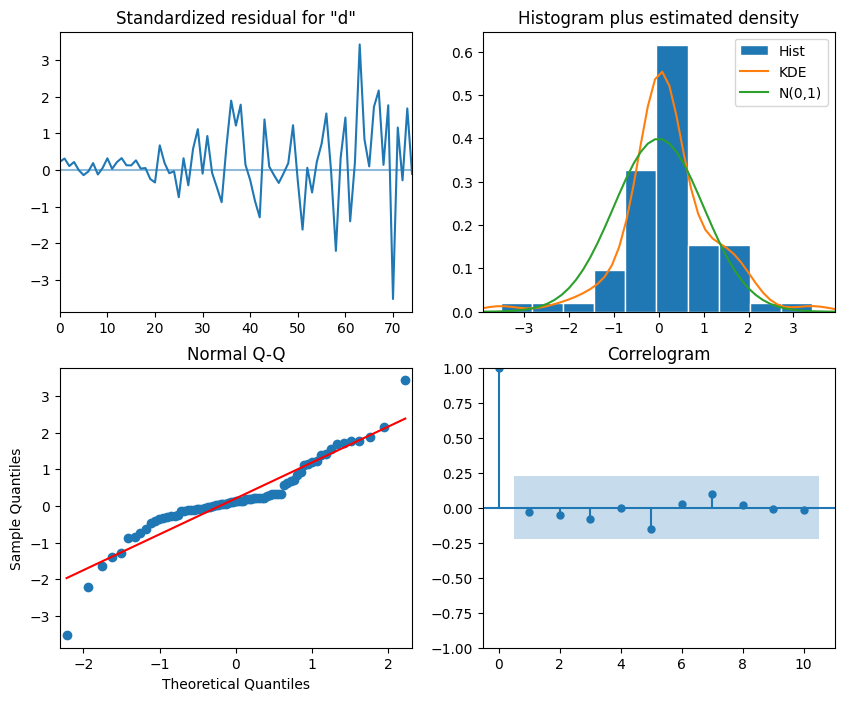

In [60]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [61]:
# 융-박스 테스트
residuals = SARIMA_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [62]:
# 예측 및 테스트 집합의 관측값과 비교
SARIMA_pred = SARIMA_model_fit.get_prediction(80, 83).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

,date,data,SARIMA_pred
80,1980-01-01,16.20,16.531419
81,1980-04-01,14.67,14.094891
82,1980-07-02,16.02,17.285146
83,1980-10-01,11.61,11.382462


In [63]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [64]:
# 성능 평가
mape_SARIMA = mape(test['data'], test['SARIMA_pred'])

print(mape_SARIMA)

3.955809442830645


# 9.4.1 SARIMAX 모델에 모든 외생 변수를 사용하여 실질 GDP 예측하기

이번 장의 본문에서는 실질 GDP를 예측할 때 외생 변수의 수를 제한했다. 이번 연습에서는 모든
외생 변수를 사용하여 SARIMAX 모델을 피팅하고 더 나은 성능을 얻을 수 있는지 확인한다.
1. SARIMAX 모델에 모든 외생 변수를 사용한다.
2. 잔차분석을수행한다.
3. 데이터 집합의 마지막 7개 시간 단계에 대한 예측을 생성한다.
4. MAPE를 측정한다. 제한된 수의 외생 변수를 사용하여 얻은 결과보다 더 나은지, 더 나쁜지,
아니면 동일한지 확인한다.

In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [66]:
# 데이터 집합 로딩
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


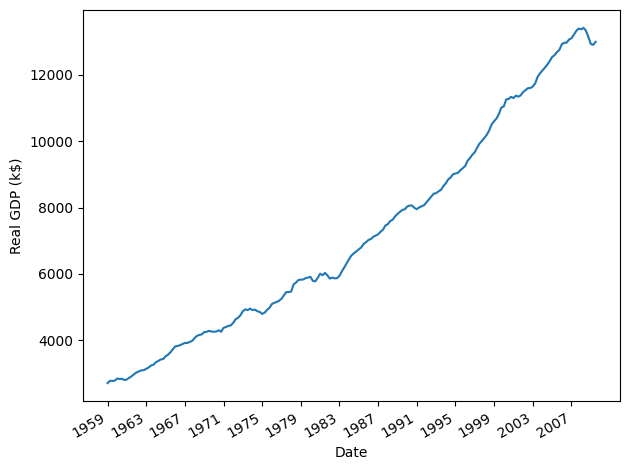

In [67]:
# 도식화
fig, ax = plt.subplots()

ax.plot(macro_econ_data['realgdp'])
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

In [68]:
# 대상 변수 및 외생 변수 정의
target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi',
                        'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']]

In [69]:
# 정상성 테스트 -> 비정상
ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.7504627967647144
p-value: 0.9982455372335032


In [70]:
# 1차 차분 및 정상서 테스트 -> 정상
target_diff = target.diff()

ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.305695561658106
p-value: 3.327882187668224e-08


In [71]:
# 모든 고유한 SARIMAX 모델을 피팅하는 함수 정의
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [72]:
# 목표 변수와 외생 변수의 훈련 집합 생성
target_train = target[:200]
exog_train = exog[:200]

In [73]:
# 차수에 대해 가능한 값의 범위 정의
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 4 # 분기별 수집

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [74]:
# SARIMAX 함수 실행 -> SARIMAX(2,1,2)(1,0,0)4
result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 2, 1, 0)",1757.107242
1,"(3, 3, 0, 0)",1757.890596
2,"(2, 2, 0, 2)",1758.333051
3,"(2, 2, 0, 0)",1759.093324
4,"(2, 2, 2, 0)",1759.587883
...,...,...
251,"(3, 2, 2, 1)",1776.806679
252,"(3, 2, 1, 3)",1776.867132
253,"(3, 2, 1, 1)",1776.944899
254,"(3, 2, 1, 2)",1778.131896


In [75]:
# 모델 피팅 및 요약 테이블 생성
best_model = SARIMAX(target_train, exog_train, order=(2,1,2), seasonal_order=(1,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                            realgdp   No. Observations:                  200
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 4)   Log Likelihood                -861.554
Date:                            Tue, 15 Apr 2025   AIC                           1757.107
Time:                                    07:39:17   BIC                           1813.093
Sample:                                         0   HQIC                          1779.766
                                            - 200                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9570      0.053     17.973      0.000       0.853       1.061
realinv        1.0018      0.042   

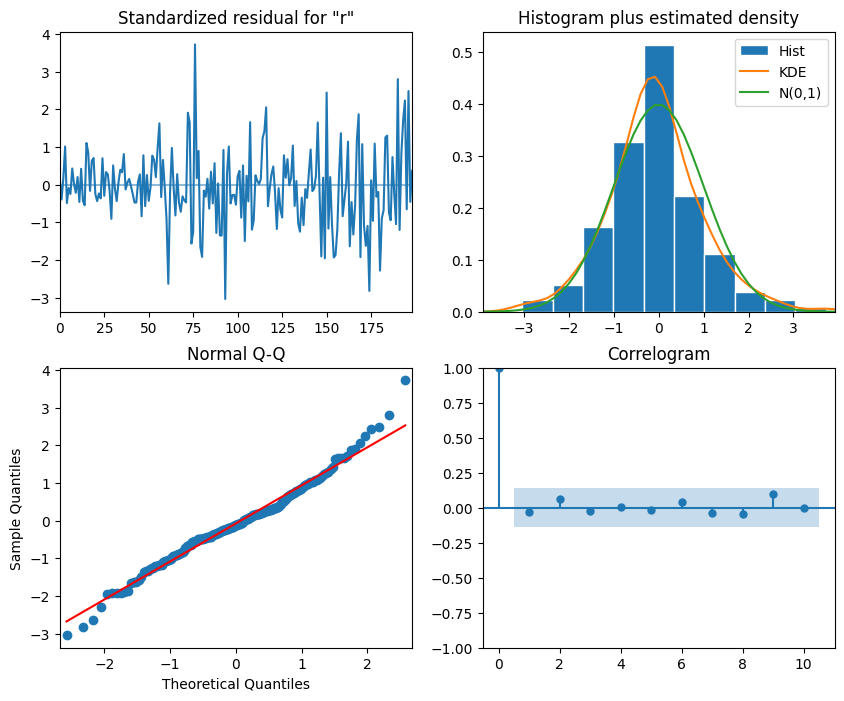

In [76]:
# 잔차 분석 -> 잔차가 백색소음과 유사하다
best_model_fit.plot_diagnostics(figsize=(10,8));

In [77]:
# 융-박스 테스트 -> 잔차가 독립적이고 상관관계가 없다
residuals = best_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [78]:
# 다음 시간 단계를 여러 번 예측하는 함수
def rolling_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'SARIMAX':
        pred_SARIMAX = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(2,1,2), seasonal_order=(1,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)

        return pred_SARIMAX

In [79]:
# 예측
target_train = target[:196]
target_test = target[196:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1 # 다음 시간 단계만 예측

pred_last_value = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = rolling_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13345.323465
197,13415.266,13366.865,13374.991346
198,13324.600,13415.266,13368.458066
199,13141.920,13324.600,13332.370212
200,12925.410,13141.920,13135.312953
201,12901.504,12925.410,12887.761999
202,12990.341,12901.504,12868.822028


In [80]:
# 평균절대백분율오차 함수 정의
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [81]:
# 성능 평가
mape_last = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

0.736849498653785 0.70080434122877


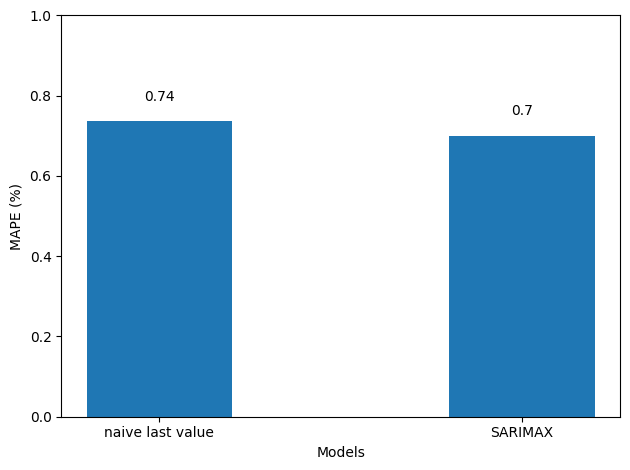

In [82]:
# 도식화
fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()